# Amazn Food Review Sentiment Analysis

In [1]:
# Importing libraries
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import mlflow
import mlflow.sklearn

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    f1_score, accuracy_score, classification_report, 
    recall_score, precision_score, roc_auc_score, roc_curve
)

[nltk_data] Downloading package stopwords to C:\Users\Tridev
[nltk_data]     Kongara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load the data
amr = pd.read_csv('Reviews.csv')

## Dataset Overview

In [3]:
# Check the header and a few rows of data for dataset
amr.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Check column types, missing values
amr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
# Get summary statistics
amr.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [6]:
#total rows in the dataset
print("Total number of rows:", len(amr))

#Stats of dataset
count_unique_reviews = pd.DataFrame({
    'count': amr.count(),
    'unique': amr.nunique()
})

print(count_unique_reviews)

Total number of rows: 568454
                         count  unique
Id                      568454  568454
ProductId               568454   74258
UserId                  568454  256059
ProfileName             568428  218415
HelpfulnessNumerator    568454     231
HelpfulnessDenominator  568454     234
Score                   568454       5
Time                    568454    3168
Summary                 568427  295742
Text                    568454  393579


-----------------------------------------------------------------------------------------------------------------------------------
Predict the sentiment (Positive or Negative) of a review based on the actual written text.</br>
</br>
So the only input that really matters for prediction is: </br>
</br>
**Text**: The full written review</br>
**Score:**: The label (further modified)</br>
</br>
The other columns that are not useful for sentiment prediction:</br>
</br>
**Id**:	Just a unique row identifier; has no relationship with sentiment.</br>
**ProductId**: This is a product code; not useful for our sentiment prediction.</br>
**UserId**:	A random user ID; not useful for our sentiment prediction. Also privacy-sensitive.</br>
**ProfileName**: Name of the reviewer; irrelevant to the review content.</br>
**Helpfulness Numerator/Denominator**:	Shows how many users found the review helpful, but this doesn't mean the review is positive or negative. A helpful review can still be negative!</br>
**Time**: Timestamp of the review;; not useful for our sentiment prediction.</br>
**Summary**: A short title for the review. As we are focusing on the full review in Text, it is optional.</br>
</br>
So, dropping the columns above and using only Text and score for our sentiment analysis.
</br>
</br>

In [7]:
# considering only Text and Score for sentiment analsis as others are not so useful
amr = amr[['Text', 'Score','Time']]

In [8]:
# checking the number of duplicate rows in the dataset
amr.duplicated().sum()

np.int64(174493)

In [9]:
# checking the number of duplicate values in the Text column in the dataset
amr.duplicated(subset='Text').sum()

np.int64(174875)

In [10]:
# displaying the duplicate Text values
amr[amr.duplicated(subset='Text')].head()

,Text,Score,Time
29,I don't know if it's the cactus or the tequila...,5,1107820800
574,"I'm addicted to salty and tangy flavors, so wh...",5,1231718400
603,"I'm addicted to salty and tangy flavors, so wh...",5,1229385600
1973,The pork chops from Omaha Steaks were very tas...,3,1312675200
2309,Too much of the white pith on this orange peel...,2,1127606400


In [11]:
# removing the duplicate values from the datset
amr.drop_duplicates(subset='Text', inplace=True)

In [12]:
amr.duplicated(subset='Text').sum()

np.int64(0)

We are doing a sentimental analysis that Classifies a review as either Positive or Negative, it's a binary classification problem </br>
Neutral reviews are those where the Score is 3 (on a 1–5 scale). These reviews:</br>
    - Are neither positive nor negative </br>
    - Often express mixed or balanced opinions</br>
Neutral reviews introduce ambiguity, so removing them and changing positive reviews as 1 and negative review as 0 sentiment, dropping the original score column, and introducing sentiment column

In [13]:
# Remove neutral reviews
amr = amr[amr['Score'] != 3]

# Map scores to sentiment labels
amr['Sentiment'] = amr['Score'].apply(lambda rating: 1 if rating > 3 else 0)

# Drop original Score column
amr.drop('Score', axis=1, inplace=True)

amr.head()

,Text,Time,Sentiment
0,I have bought several of the Vitality canned d...,1303862400,1
1,Product arrived labeled as Jumbo Salted Peanut...,1346976000,0
2,This is a confection that has been around a fe...,1219017600,1
3,If you are looking for the secret ingredient i...,1307923200,0
4,Great taffy at a great price. There was a wid...,1350777600,1


Removing the punctuation and stop words from the text to reduce noise, improve model efficiency, and focus the learning on words that actually carry sentiment and meaning. </br>
stop words include removing no, nor, not words by default, as these words have impact on reviews, not considering them as stop words and inludung them in the cleaaned text.

In [14]:
stop_words = set(stopwords.words('english'))

negation_words = {'no', 'nor', 'not'}
stop_words = stop_words - negation_words  # Keep them!

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stopwords
    return text

amr['Cleaned_Text'] = amr['Text'].apply(clean_text)

amr[['Text', 'Cleaned_Text', 'Sentiment']].head()


,Text,Cleaned_Text,Sentiment
0,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,1
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...,0
2,This is a confection that has been around a fe...,confection around centuries light pillowy citr...,1
3,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,0
4,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,1


## Exploratory Data Analysis

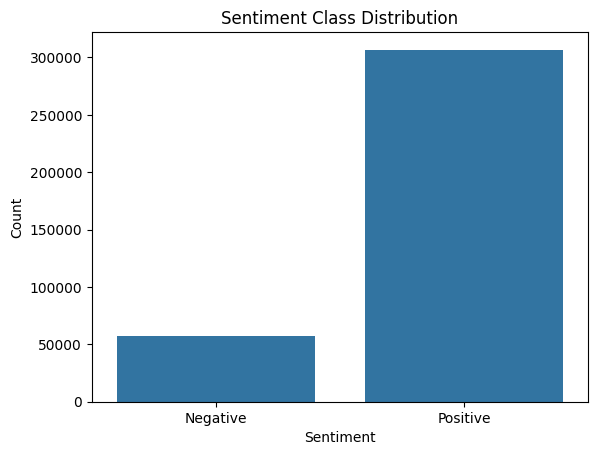

In [15]:
# Sentiment Class Distribution

# A bar graph that show the number of positive and negative class distribution in the dataset

# Plot class balance
sns.countplot(data=amr, x='Sentiment')
plt.title('Sentiment Class Distribution')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


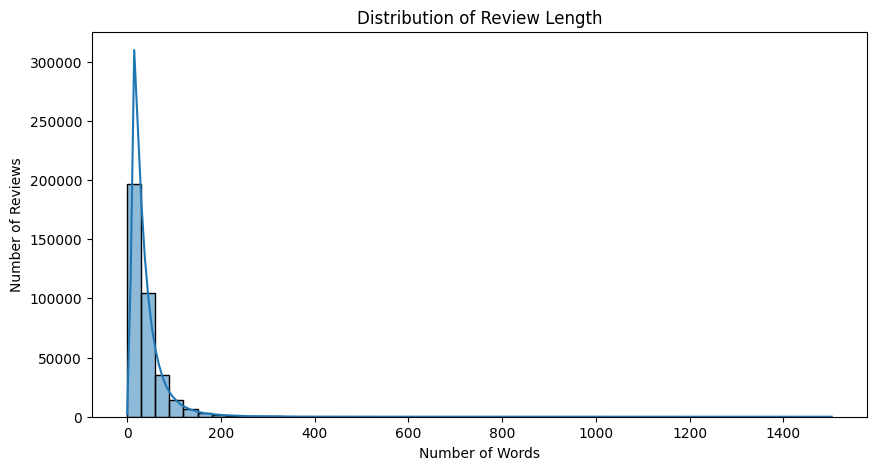

In [16]:
# Review Length Analysis

# Helps in identify if very short or long reviews dominate the dataset

# Add a column for review length
amr['Review_Length'] = amr['Cleaned_Text'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(amr['Review_Length'], bins=50, kde=True)
plt.title('Distribution of Review Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()


C:\Users\Tridev Kongara\AppData\Local\Temp\ipykernel_20384\805113193.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, y='Word', x='Count', palette='Greens_r')
C:\Users\Tridev Kongara\AppData\Local\Temp\ipykernel_20384\805113193.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=neg_df, y='Word', x='Count', palette='Reds_r')


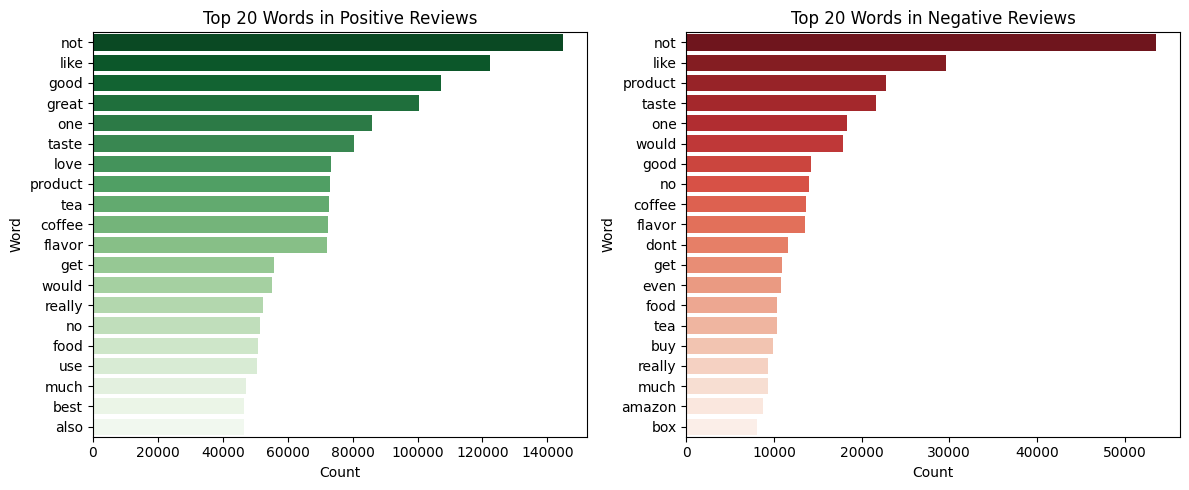

In [17]:
# Most Common Words in Each Sentiment

# Split positive and negative reviews
positive_words = ' '.join(amr[amr['Sentiment'] == 1]['Cleaned_Text']).split()
negative_words = ' '.join(amr[amr['Sentiment'] == 0]['Cleaned_Text']).split()

# Get most common 20 words
pos_common = Counter(positive_words).most_common(20)
neg_common = Counter(negative_words).most_common(20)

# Convert to DataFrame for plotting
pos_df = pd.DataFrame(pos_common, columns=['Word', 'Count'])
neg_df = pd.DataFrame(neg_common, columns=['Word', 'Count'])

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=pos_df, y='Word', x='Count', palette='Greens_r')
plt.title('Top 20 Words in Positive Reviews')

plt.subplot(1, 2, 2)
sns.barplot(data=neg_df, y='Word', x='Count', palette='Reds_r')
plt.title('Top 20 Words in Negative Reviews')

plt.tight_layout()
plt.show()


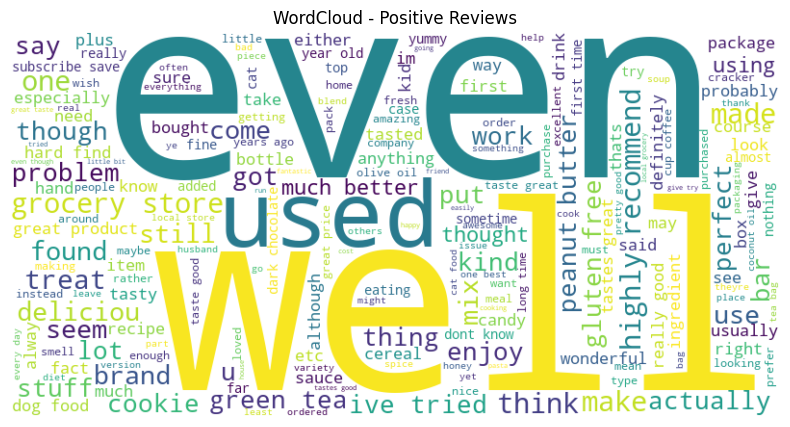

In [18]:
# WordCloud

# Generate for positive reviews
pos_wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Positive Reviews')
plt.show()

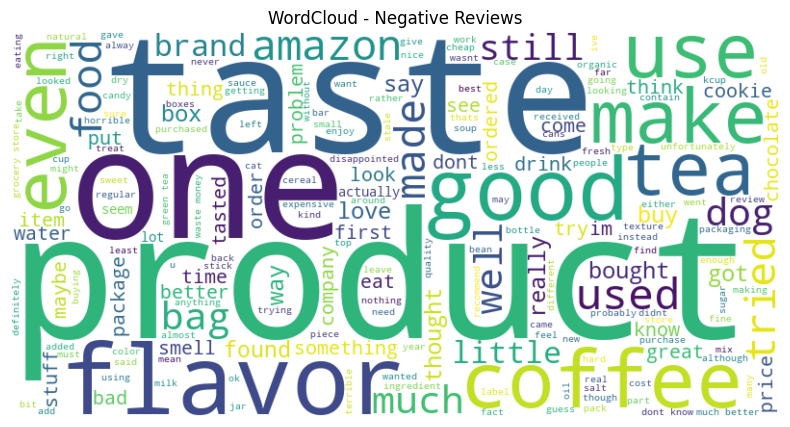

In [19]:
# Generate for negative reviews
pos_wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_words))
plt.figure(figsize=(10, 5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negative Reviews')
plt.show()


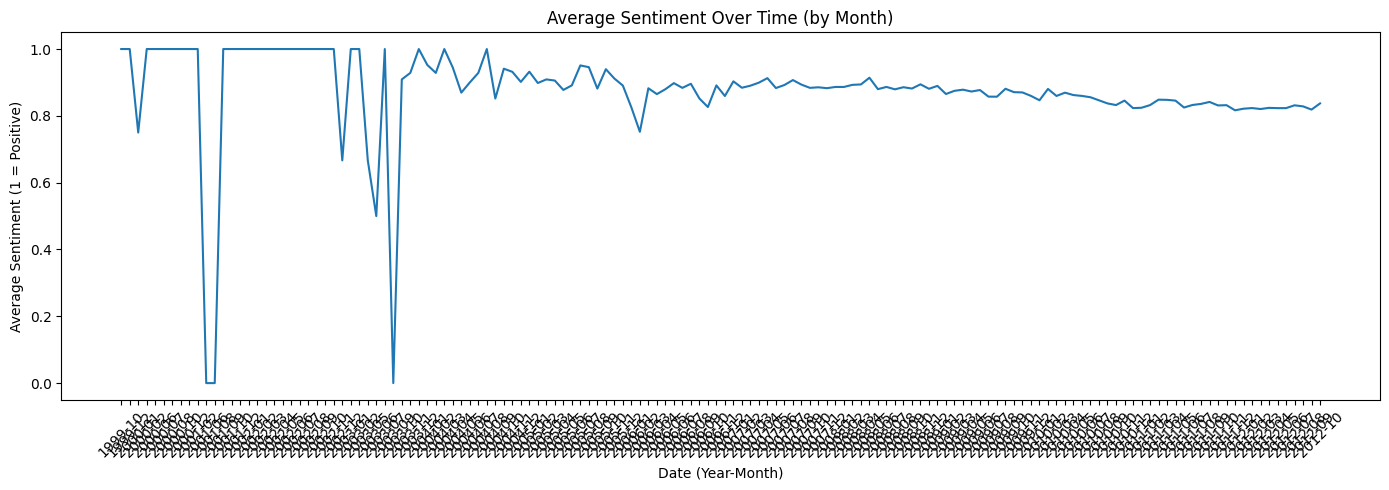

In [20]:
# Time-based Sentiment Trend

# Helps visualize whether customer sentiment is improving, declining, or remaining stable month over month.

# Useful for tracking brand reputation over time.

# 1. Convert UNIX timestamp to datetime
amr['Review_Date'] = pd.to_datetime(amr['Time'], unit='s')

# 2. Group reviews by month and calculate average sentiment
monthly_sentiment = (
    amr.groupby(amr['Review_Date'].dt.to_period('M'))['Sentiment']
    .mean()
    .reset_index()
)

# 3. Convert 'Review_Date' from Period to String (for plotting)
monthly_sentiment['YearMonth'] = monthly_sentiment['Review_Date'].astype(str)

# 4. Plot time-based sentiment trend
plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly_sentiment, x='YearMonth', y='Sentiment')
plt.xticks(rotation=45)
plt.title('Average Sentiment Over Time (by Month)')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Average Sentiment (1 = Positive)')
plt.tight_layout()
plt.show()



# Machine Learning

### Feature Extraction using TF-IDF
Convert text into numeric features that a model can understand. </br>
<b>TF-IDF Vectorizer : </b></br>
    - Counts words, but also considers how important a word is across all reviews.</br>
    - Gives higher weight to words that are unique to a document.</br>



In [21]:
tfidf = TfidfVectorizer(max_features=5000)  # limit vocab size to avoid overfitting
X = tfidf.fit_transform(amr['Cleaned_Text'])  # features
y = amr['Sentiment']                          # target

In [23]:
# # the values in x are like
# # Get feature names
# feature_names = tfidf.get_feature_names_out()

# # Convert sparse matrix to dense
# X_dense = X.toarray()

# # Convert to DataFrame for readability
# X_df = pd.DataFrame(X_dense, columns=feature_names)

# # Preview first 5 rows
# print(X_df.head())

#### Split dataset into training and testing

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Evaluation Metrics and Confusion Matrix for Model Performance

In [25]:
def metrics_score(y_test, y_pred, model):
    # Related Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Change 'binary' to 'weighted' or 'macro' for multiclass
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    model_table = pd.DataFrame([[model, accuracy, 1-recall, recall, precision, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
    
    return model_table, accuracy, precision, recall, f1, conf_matrix

## 1. Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

MLflow is used here to keep track of experiments in an organized way. It records model parameters, metrics, and the trained model itself for each run, preventing loss of information about which settings or models gave the best results. This is especially useful when testing multiple algorithms or hyperparameter combinations, as it allows easy comparison of performance in the MLflow UI and ensures the exact setup can be reproduced later. Overall, it makes the machine learning workflow more systematic, transparent, and reproducible.


2025/07/16 18:56:35 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Accuracy: 0.93
Precision: 0.94
Recall: 0.97
F1-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.66      0.74     11413
           1       0.94      0.97      0.96     61352

    accuracy                           0.93     72765
   macro avg       0.88      0.82      0.85     72765
weighted avg       0.92      0.93      0.92     72765



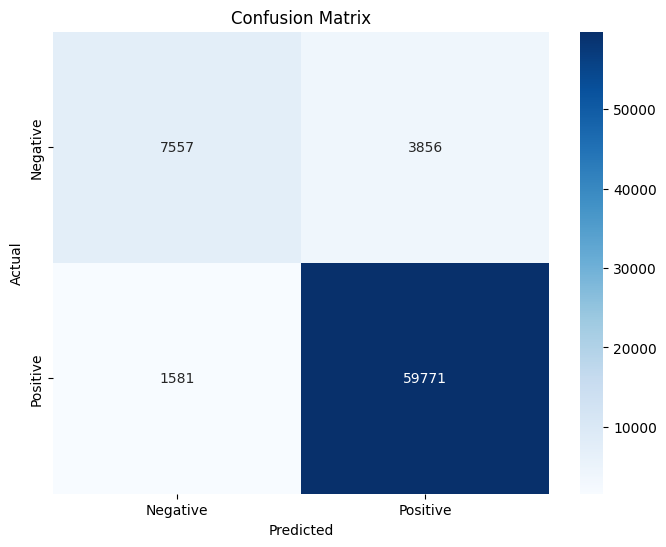

2025/07/16 18:56:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/16 18:56:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [27]:
with mlflow.start_run():
    # Train model
    lg = LogisticRegression(random_state=42, max_iter=1000)
    lg.fit(X_train, y_train)
    y_pred_lg = lg.predict(X_test)

    # Use your metrics function
    model_name = "LogisticRegression"
    lr, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred_lg, model_name)

    # Log parameters
    mlflow.log_param("model", model_name)
    mlflow.log_param("max_iter", "1000")

    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    # Log model
    mlflow.sklearn.log_model(lg, model_name)

In [28]:
results = lr
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.92528,0.025769,0.974231,0.939397,0.956497


## 2. XGBOOST

In [29]:
from xgboost import XGBClassifier
import mlflow.xgboost

Accuracy: 0.91
Precision: 0.92
Recall: 0.98
F1-Score: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.53      0.65     11413
           1       0.92      0.98      0.95     61352

    accuracy                           0.91     72765
   macro avg       0.88      0.76      0.80     72765
weighted avg       0.91      0.91      0.90     72765



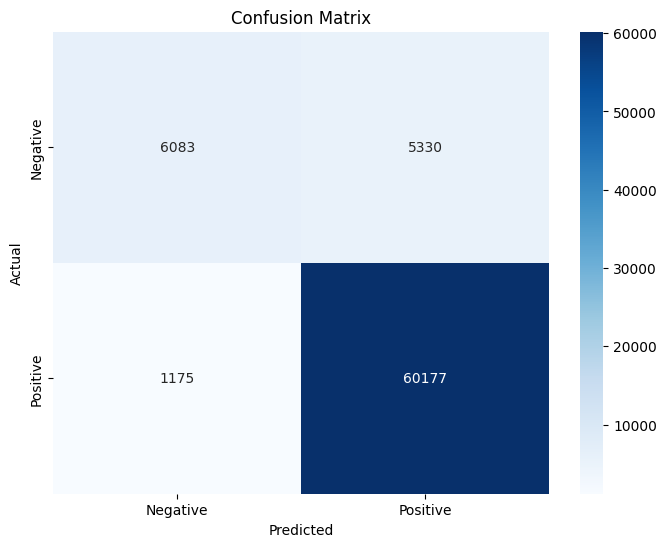

Area under Curve: 0.94


C:\Users\Tridev Kongara\anaconda3\envs\myMLenv\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [19:00:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/16 19:01:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [30]:
with mlflow.start_run():

    xgb = XGBClassifier(eval_metric='logloss', n_estimators=120, max_depth=6)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    y_proba = xgb.predict_proba(X_test)[:,1]

    # Use your metrics function
    model_name = "XGBoost"
    xg, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)
    auc = roc_auc_score(y_test, y_proba)
    print(f"Area under Curve: {auc:.2f}")
    
    # Log model hyperparameters
    mlflow.log_param("model", model_name)
    mlflow.log_param("n_estimators", 120)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("eval_metric", 'logloss')
    
    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc", auc)
    
    
    # Log the model itself
    mlflow.xgboost.log_model(xgb, name="xgboost_sentiment_model3")

In [31]:
results = pd.concat([results, xg], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723


## 3. Naive Bayesian

In [32]:
from sklearn.naive_bayes import MultinomialNB

Accuracy: 0.88
Precision: 0.88
Recall: 0.99
F1-Score: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.26      0.40     11413
           1       0.88      0.99      0.93     61352

    accuracy                           0.88     72765
   macro avg       0.89      0.63      0.67     72765
weighted avg       0.88      0.88      0.85     72765



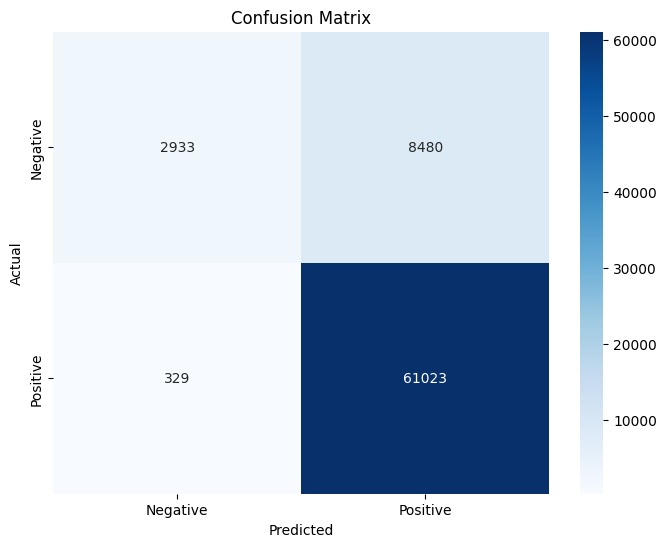

Area under Curve: 0.94


2025/07/16 19:15:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/16 19:15:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [33]:
with mlflow.start_run():

    nb1 = MultinomialNB()
    nb1.fit(X_train, y_train)
    y_pred = nb1.predict(X_test)

    y_proba = nb1.predict_proba(X_test)[:,1]

    # Use your metrics function
    model_name = "Navie Bayes"
    nba, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)
    auc = roc_auc_score(y_test, y_proba)
    print(f"Area under Curve: {auc:.2f}")
    
    # Log model hyperparameters
    mlflow.log_param("model", model_name)
    
    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc", auc)
    
    # Log the model itself
    mlflow.sklearn.log_model(nb1, model_name)

In [34]:
results = pd.concat([results, nba], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681


## 4. SVM

In [35]:
from sklearn.svm import LinearSVC

Accuracy: 0.93
Precision: 0.94
Recall: 0.97
F1-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74     11413
           1       0.94      0.97      0.96     61352

    accuracy                           0.93     72765
   macro avg       0.88      0.83      0.85     72765
weighted avg       0.92      0.93      0.92     72765



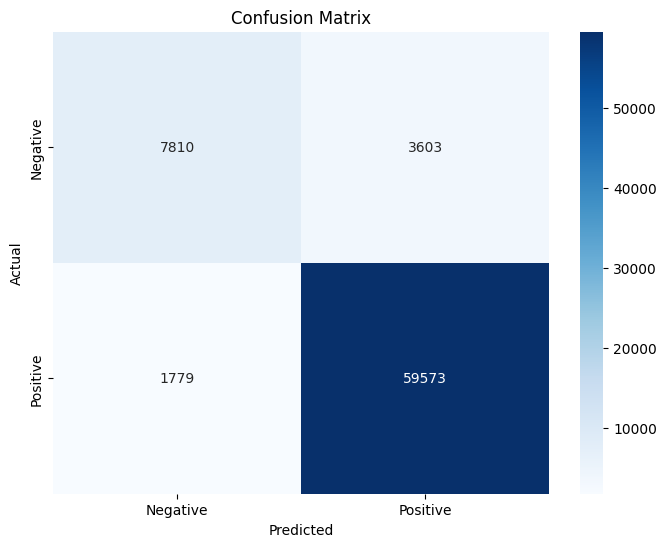

2025/07/16 19:15:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/16 19:15:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [36]:
with mlflow.start_run():

    svm = LinearSVC(random_state = 42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    # y_proba = svm.predict_proba(X_test)[:,1]

    # Use your metrics function
    model_name = "SVM"
    sv, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)
    # auc = roc_auc_score(y_test, y_proba)
    # print(f"Area under Curve: {auc:.2f}")
    
    # Log model hyperparameters
    mlflow.log_param("model", model_name)
    
    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    # mlflow.log_metric("auc", auc)
    
    # Log the model itself
    mlflow.sklearn.log_model(svm, model_name)

In [37]:
results = pd.concat([results, sv], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781


## 5. Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.90
Precision: 0.91
Recall: 0.99
F1-Score: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.46      0.60     11413
           1       0.91      0.99      0.95     61352

    accuracy                           0.90     72765
   macro avg       0.88      0.73      0.77     72765
weighted avg       0.90      0.90      0.89     72765



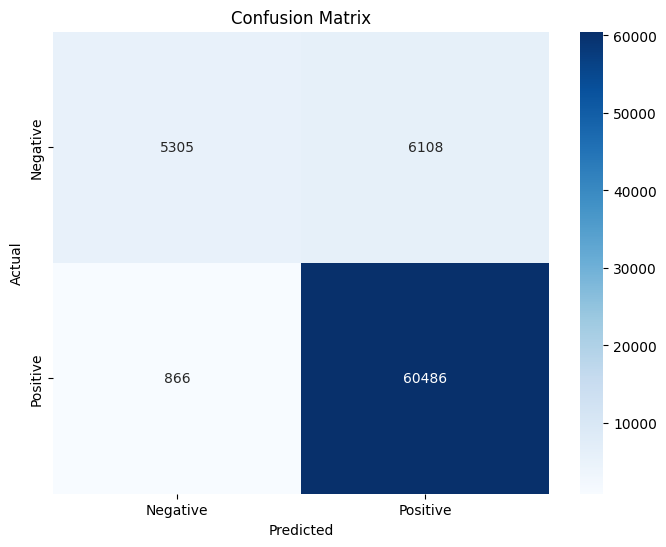

2025/07/17 11:38:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/17 11:38:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [42]:
with mlflow.start_run():

    rf = RandomForestClassifier(random_state = 42, class_weight = 'balanced', n_estimators = 110, criterion = 'entropy', min_samples_split = 3)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # y_proba = svm.predict_proba(X_test)[:,1]

    # Use your metrics function
    model_name = "Random Forest"
    ra, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)
    # auc = roc_auc_score(y_test, y_proba)
    # print(f"Area under Curve: {auc:.2f}")
    
    # Log model hyperparameters
    mlflow.log_param("model", model_name)
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("n_estimators", 110)
    mlflow.log_param("criterion", "entropy")
    mlflow.log_param("min_samples_split", 3)
    
    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)
    # mlflow.log_metric("auc", auc)
    
    # Log the model itself
    mlflow.sklearn.log_model(rf, model_name)

In [43]:
results = pd.concat([results, ra], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781
4,Random Forest,0.904157,0.014115,0.985885,0.908280,0.945493


## 6. Voting Classifier

In [44]:
from sklearn.ensemble import VotingClassifier

In [45]:
voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('nb', MultinomialNB()),
    ('svm', LinearSVC())
], voting='hard')

In [46]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('nb', MultinomialNB()), ('svm', LinearSVC())])

In [47]:
y_pred = voting.predict(X_test)

Accuracy: 0.93
Precision: 0.94
Recall: 0.98
F1-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.73     11413
           1       0.94      0.98      0.96     61352

    accuracy                           0.93     72765
   macro avg       0.89      0.81      0.84     72765
weighted avg       0.92      0.93      0.92     72765



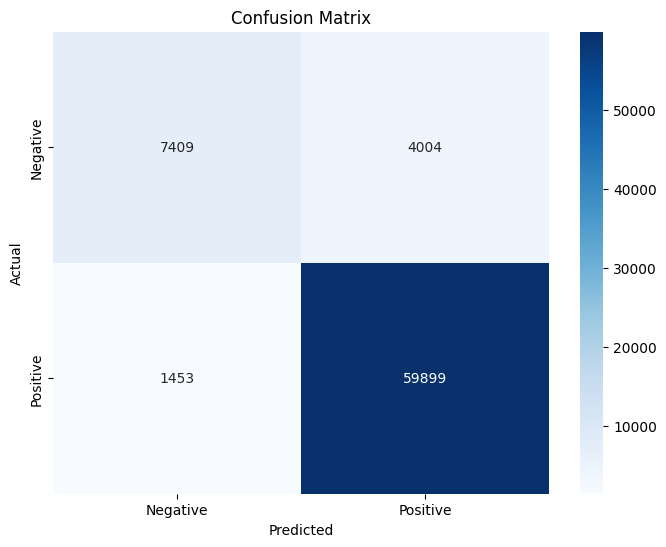

In [48]:
# Use your metrics function
model_name = "Ensemble Methods"
es, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)

In [49]:
results = pd.concat([results, es], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781
4,Random Forest,0.904157,0.014115,0.985885,0.908280,0.945493
5,Ensemble Methods,0.925005,0.023683,0.976317,0.937343,0.956433


## 7. Stacking Classifier

In [50]:
from sklearn.ensemble import StackingClassifier

In [51]:
stack = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('nb', MultinomialNB()),
        ('svm', LinearSVC())
    ],
    final_estimator=RandomForestClassifier()
)

In [52]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('nb', MultinomialNB()), ('svm', LinearSVC())],
                   final_estimator=RandomForestClassifier())

In [53]:
y_pred = stack.predict(X_test)

Accuracy: 0.92
Precision: 0.95
Recall: 0.96
F1-Score: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74     11413
           1       0.95      0.96      0.95     61352

    accuracy                           0.92     72765
   macro avg       0.86      0.84      0.85     72765
weighted avg       0.92      0.92      0.92     72765



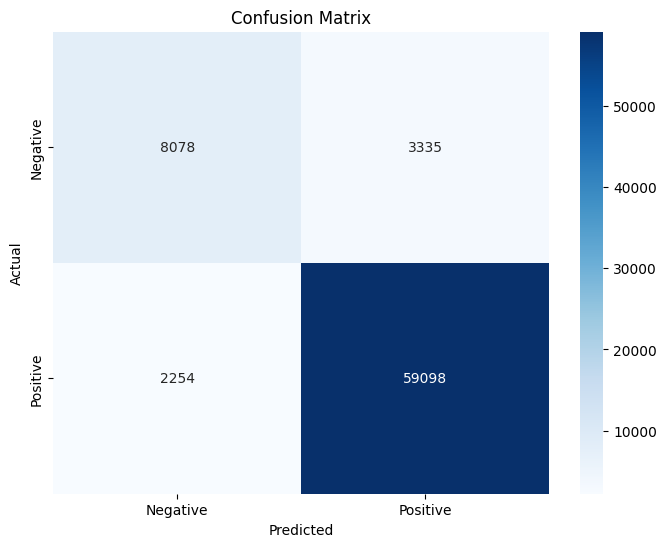

In [54]:
# Use your metrics function
model_name = "stacking Classifier"
sc, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)

In [55]:
results = pd.concat([results, sc], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781
4,Random Forest,0.904157,0.014115,0.985885,0.908280,0.945493
5,Ensemble Methods,0.925005,0.023683,0.976317,0.937343,0.956433
6,stacking Classifier,0.923191,0.036739,0.963261,0.946583,0.954849


## 8. Neural Networks

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Limiting the max features because of Memory

In [58]:
tfidf = TfidfVectorizer(max_features=1000)  # limit vocab size to avoid overfitting
X = tfidf.fit_transform(amr['Cleaned_Text'])  # features
y = amr['Sentiment']                          # target

Splitting the data with max features as 1000

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [62]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train.toarray(), y_train, epochs=5, batch_size=64, validation_split=0.1)

C:\Users\Tridev Kongara\anaconda3\envs\myMLenv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8922 - loss: 0.2648 - val_accuracy: 0.9108 - val_loss: 0.2171
Epoch 2/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9152 - loss: 0.2089 - val_accuracy: 0.9128 - val_loss: 0.2101
Epoch 3/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9194 - loss: 0.2008 - val_accuracy: 0.9159 - val_loss: 0.2054
Epoch 4/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9262 - loss: 0.1863 - val_accuracy: 0.9173 - val_loss: 0.2021
Epoch 5/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9301 - loss: 0.1765 - val_accuracy: 0.9183 - val_loss: 0.2001


In [63]:
# Predict probabilities
y_proba = model.predict(X_test.toarray())

# Convert to binary class labels
y_pred = (y_proba >= 0.5).astype(int)

# If you want to flatten to a 1D array
y_pred = y_pred.flatten()

2274/2274 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


Accuracy: 0.92
Precision: 0.94
Recall: 0.97
F1-Score: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.64      0.71     11413
           1       0.94      0.97      0.95     61352

    accuracy                           0.92     72765
   macro avg       0.87      0.81      0.83     72765
weighted avg       0.92      0.92      0.92     72765



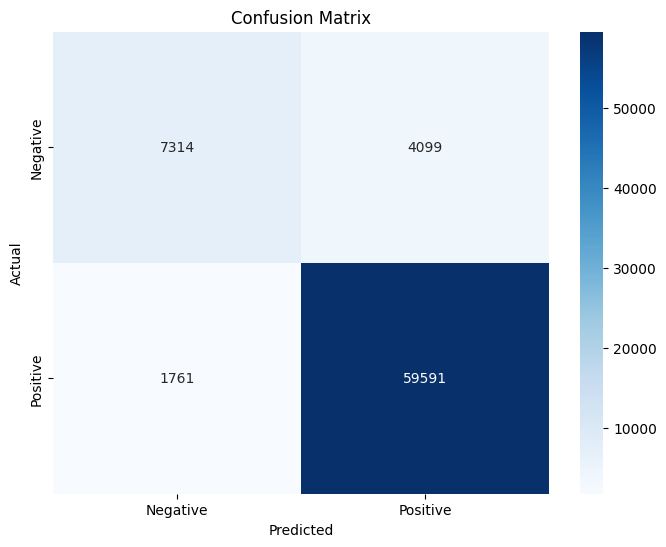

In [64]:
# Use your metrics function
model_name = "Neural Network1"
nn1, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)

In [65]:
results = pd.concat([results, nn1], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781
4,Random Forest,0.904157,0.014115,0.985885,0.908280,0.945493
5,Ensemble Methods,0.925005,0.023683,0.976317,0.937343,0.956433
6,stacking Classifier,0.923191,0.036739,0.963261,0.946583,0.954849
7,Neural Network1,0.919467,0.028703,0.971297,0.935641,0.953136


## 9. LSTM (Long Short-Term Memory) a RNN 

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

TF-IDF does not work for LSTM and CNN. It requires word embeddings

In [67]:
# Example using your cleaned text dataframe 'amr'
texts = amr['Cleaned_Text'].astype(str).tolist()
labels = amr['Sentiment'].tolist()

# Tokenizer
vocab_size = 10000  # adjust as needed
max_length = 200
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')


In [68]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels
)
y_train = np.array(y_train)

In [69]:
from tensorflow.keras.layers import Embedding, LSTM

In [70]:
embedding_dim = 64

model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# Training
history = model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


C:\Users\Tridev Kongara\anaconda3\envs\myMLenv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 891s 217ms/step - accuracy: 0.8432 - loss: 0.4390 - val_accuracy: 0.8442 - val_loss: 0.4331
Epoch 2/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 816s 199ms/step - accuracy: 0.8447 - loss: 0.4338 - val_accuracy: 0.8442 - val_loss: 0.4326
Epoch 3/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 1328s 324ms/step - accuracy: 0.8427 - loss: 0.4361 - val_accuracy: 0.8438 - val_loss: 0.4333
Epoch 4/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 1878s 459ms/step - accuracy: 0.8442 - loss: 0.4328 - val_accuracy: 0.9098 - val_loss: 0.2291
Epoch 5/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 1454s 355ms/step - accuracy: 0.9262 - loss: 0.1932 - val_accuracy: 0.9364 - val_loss: 0.1646


In [71]:
# Predict probabilities
y_pred_proba = model_lstm.predict(X_test)

2274/2274 ━━━━━━━━━━━━━━━━━━━━ 269s 118ms/step


In [72]:
# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_proba > 0.4).astype("int32").flatten()

Accuracy: 0.94
Precision: 0.95
Recall: 0.97
F1-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79     11413
           1       0.95      0.97      0.96     61352

    accuracy                           0.94     72765
   macro avg       0.89      0.86      0.88     72765
weighted avg       0.93      0.94      0.94     72765



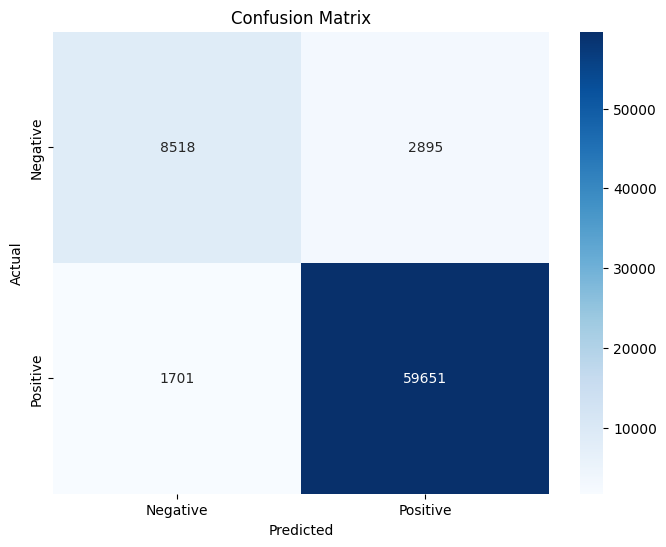

In [73]:
model_name = "LSTM"
lstm_m, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)

In [74]:
results = pd.concat([results, lstm_m], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781
4,Random Forest,0.904157,0.014115,0.985885,0.908280,0.945493
5,Ensemble Methods,0.925005,0.023683,0.976317,0.937343,0.956433
6,stacking Classifier,0.923191,0.036739,0.963261,0.946583,0.954849
7,Neural Network1,0.919467,0.028703,0.971297,0.935641,0.953136
8,LSTM,0.936838,0.027725,0.972275,0.953714,0.962905


## 10. CNN 

In [75]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

In [76]:
embedding_dim = 64

model_cnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

# Training
history = model_cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


C:\Users\Tridev Kongara\anaconda3\envs\myMLenv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 157s 38ms/step - accuracy: 0.8936 - loss: 0.2614 - val_accuracy: 0.9359 - val_loss: 0.1645
Epoch 2/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 188s 46ms/step - accuracy: 0.9409 - loss: 0.1539 - val_accuracy: 0.9388 - val_loss: 0.1574
Epoch 3/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 181s 44ms/step - accuracy: 0.9547 - loss: 0.1222 - val_accuracy: 0.9374 - val_loss: 0.1624
Epoch 4/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 175s 43ms/step - accuracy: 0.9642 - loss: 0.0977 - val_accuracy: 0.9372 - val_loss: 0.1756
Epoch 5/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 198s 48ms/step - accuracy: 0.9719 - loss: 0.0778 - val_accuracy: 0.9345 - val_loss: 0.1969


In [77]:
# Predict probabilities
y_pred_proba = model_cnn.predict(X_test)

2274/2274 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


In [78]:
# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_proba > 0.4).astype("int32").flatten()

Accuracy: 0.93
Precision: 0.94
Recall: 0.98
F1-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.68      0.76     11413
           1       0.94      0.98      0.96     61352

    accuracy                           0.93     72765
   macro avg       0.90      0.83      0.86     72765
weighted avg       0.93      0.93      0.93     72765



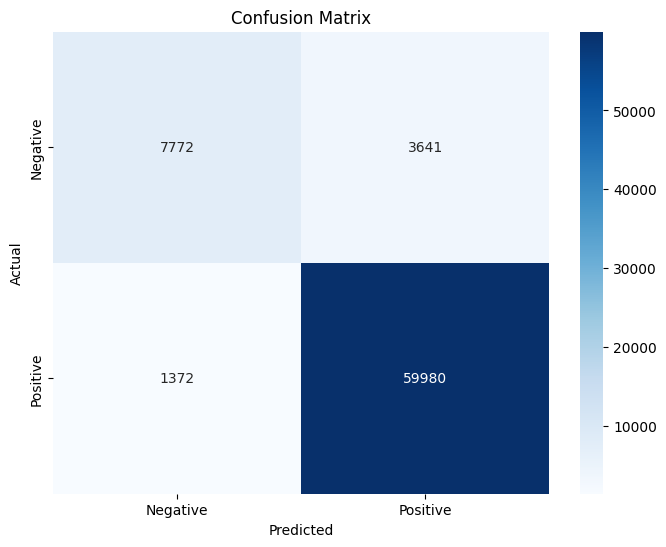

In [79]:
model_name = "CNN1"
cnn_m, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)

In [80]:
results = pd.concat([results, cnn_m], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781
4,Random Forest,0.904157,0.014115,0.985885,0.908280,0.945493
5,Ensemble Methods,0.925005,0.023683,0.976317,0.937343,0.956433
6,stacking Classifier,0.923191,0.036739,0.963261,0.946583,0.954849
7,Neural Network1,0.919467,0.028703,0.971297,0.935641,0.953136
8,LSTM,0.936838,0.027725,0.972275,0.953714,0.962905
9,CNN1,0.931107,0.022363,0.977637,0.942770,0.959887


## 11. LSTM + CNN 

In [81]:
from tensorflow.keras.layers import MaxPooling1D

In [82]:
embedding_dim = 64

model_cnn_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn_lstm.summary()

# Training
history = model_cnn_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


C:\Users\Tridev Kongara\anaconda3\envs\myMLenv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 5319s 1s/step - accuracy: 0.8437 - loss: 0.4402 - val_accuracy: 0.8443 - val_loss: 0.4326
Epoch 2/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 534s 130ms/step - accuracy: 0.8438 - loss: 0.4276 - val_accuracy: 0.9116 - val_loss: 0.2154
Epoch 3/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 1297s 317ms/step - accuracy: 0.9285 - loss: 0.1842 - val_accuracy: 0.9400 - val_loss: 0.1591
Epoch 4/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 969s 237ms/step - accuracy: 0.9510 - loss: 0.1304 - val_accuracy: 0.9405 - val_loss: 0.1554
Epoch 5/5
4094/4094 ━━━━━━━━━━━━━━━━━━━━ 545s 133ms/step - accuracy: 0.9660 - loss: 0.0950 - val_accuracy: 0.9419 - val_loss: 0.1554


In [83]:
# Predict probabilities
y_pred_proba = model_cnn_lstm.predict(X_test)

2274/2274 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step 


In [84]:
# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_proba > 0.3).astype("int32").flatten()

Accuracy: 0.94
Precision: 0.95
Recall: 0.98
F1-Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.79     11413
           1       0.95      0.98      0.96     61352

    accuracy                           0.94     72765
   macro avg       0.91      0.85      0.87     72765
weighted avg       0.94      0.94      0.94     72765



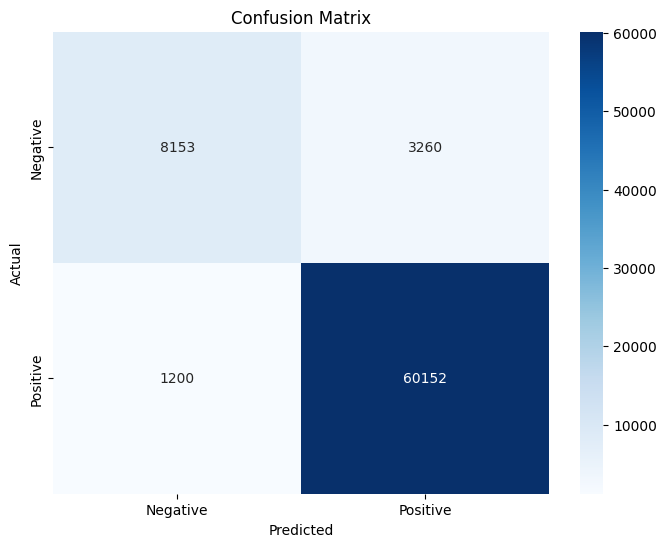

In [85]:
model_name = "LSTM_CNN"
model_lstm_cnn, acc, prec, rec, f1, conf_matrix = metrics_score(y_test, y_pred, model_name)

In [86]:
results = pd.concat([results, model_lstm_cnn], ignore_index=True)
results

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,LogisticRegression,0.925280,0.025769,0.974231,0.939397,0.956497
1,XGBoost,0.910603,0.019152,0.980848,0.918635,0.948723
2,Navie Bayes,0.878939,0.005362,0.994638,0.877991,0.932681
3,SVM,0.926036,0.028997,0.971003,0.942969,0.956781
4,Random Forest,0.904157,0.014115,0.985885,0.908280,0.945493
5,Ensemble Methods,0.925005,0.023683,0.976317,0.937343,0.956433
6,stacking Classifier,0.923191,0.036739,0.963261,0.946583,0.954849
7,Neural Network1,0.919467,0.028703,0.971297,0.935641,0.953136
8,LSTM,0.936838,0.027725,0.972275,0.953714,0.962905
9,CNN1,0.931107,0.022363,0.977637,0.942770,0.959887
